In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/Share/home/shibinbin/projects/Deepfold2


In [4]:
import h5py
import pandas as pd

In [8]:
metrics = []
for dataset in ('cellfree_SHAPE', 'incell_SHAPE', 'kasugamycin_SHAPE'):
    for model in ('basic', 'mlp1', 'conv1', 'resnet1'):
        with h5py.File('output/patteRNA/SHAPE-MaP/Cell_2018_{0}.metrics/w=128.m={1}'.format(dataset, model), 'r') as f:
            metrics.append((dataset, model, f['/metrics/roc_auc'][()], f['/metrics/accuracy'][()]))
metrics = pd.DataFrame.from_records(metrics, columns=('dataset', 'model', 'roc_auc', 'accuracy'))
metrics

,dataset,model,roc_auc,accuracy
0,cellfree_SHAPE,basic,0.645807,0.609097
1,cellfree_SHAPE,mlp1,0.676434,0.624928
2,cellfree_SHAPE,conv1,0.693936,0.640473
3,cellfree_SHAPE,resnet1,0.659207,0.605910
4,incell_SHAPE,basic,0.688721,0.637731
5,incell_SHAPE,mlp1,0.726732,0.665909
6,incell_SHAPE,conv1,0.724880,0.661970
7,incell_SHAPE,resnet1,0.699077,0.636699
8,kasugamycin_SHAPE,basic,0.646751,0.607786
9,kasugamycin_SHAPE,mlp1,0.678158,0.628147


In [9]:
# read structures from dot files
def read_dot(filename):
    records = []
    with open(filename, 'r') as f:
        for lineno, line in enumerate(f):
            if lineno%3 == 0:
                name = line[1:].strip()
            elif lineno%3 == 1:
                seq = line.strip()
            else:
                structure = line.strip()
                records.append((name, seq, structure))
    return records

In [15]:
structures = {}
for name, seq, structure in read_dot('output/patteRNA/SHAPE-MaP/model_RNAs_domains.dot'):
    structures[name] = (np.frombuffer(bytearray(structure, encoding='ascii'), 'S1') != b'.').astype(np.int32)

In [24]:
from sklearn.metrics import roc_auc_score, accuracy_score
metrics_model_RNAs_domains = []
y_preds = {}
for dataset in ('cellfree_SHAPE', 'incell_SHAPE', 'kasugamycin_SHAPE'):
    for model in ('basic', 'mlp1', 'conv1', 'resnet1'):
        with h5py.File('output/patteRNA/SHAPE-MaP/model_RNAs_domains.predict/d=Cell_2018_{0}.w=128.m={1}'.format(dataset, model), 'r') as f:
            for name in f.keys():
                y_pred = f[name][:]
                y_preds[(dataset, model, name)] = y_pred
                metrics_model_RNAs_domains.append((dataset, model, name,
                                                  roc_auc_score(structures[name], y_pred),
                                                  accuracy_score(structures[name], (y_pred > 0.5).astype(np.int32))))
metrics_model_RNAs_domains = pd.DataFrame.from_records(metrics_model_RNAs_domains,
                                    columns=('dataset', 'model', 'seq_name', 'roc_auc', 'accuracy'))

In [ ]:
def plot_pulses(signals):
    edges = signals[1:] - signals[:-1]
    y = np.zeros(signals.shape[0] + np.sum(~np.isclose(edges, 0)), dtype=signals.dtype)
    y

[ 0  1  1  2  3  3  4  5  5  6  6  7  7  8  9 10 10 11 12 12 13 14 15 15
 16 16 17 17 18 19 19 20]
[0 0 1 1 1 0 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0 1 1]


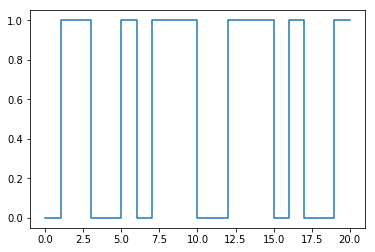

In [80]:
def pulses_to_square(signals):
    is_edge = ~np.isclose(signals[1:] - signals[:-1], 0)
    L = signals.shape[0] + np.sum(is_edge) + 1
    y = np.zeros(L, dtype=signals.dtype)
    x = np.zeros(L, dtype=np.int64)
    j = 1
    x[0] = 0
    y[0] = signals[0]
    for i in range(signals.shape[0] - 1):
        x[j] = i + 1
        y[j] = signals[i]
        j += 1
        if is_edge[i]:
            x[j] = i + 1
            y[j] = signals[i + 1]
            j += 1
    x[j] = signals.shape[0]
    y[j] = signals[-1]
    return x, y
x, y = pulses_to_square(signals)
plot(x, y)
print(x)
print(y)

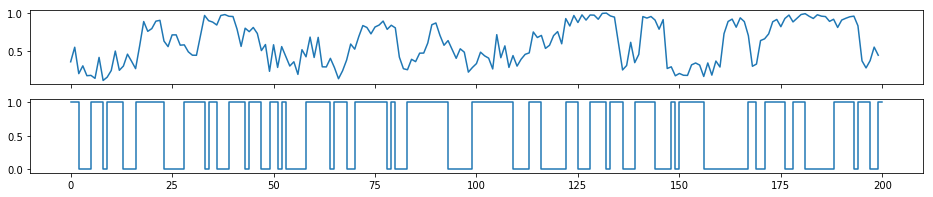

In [87]:
fig, axes = plt.subplots(2, 1, figsize=(16, 3), sharex=True)
axes[0].plot(y_preds[('cellfree_SHAPE', 'conv1', '23SRRNA-domain2')][300:500])
x, y = pulses_to_square(structures['23SRRNA-domain2'][300:500])
axes[1].plot(x, y)

In [22]:
metrics_model_RNAs_domains.groupby(['dataset', 'model'])['roc_auc'].mean()

dataset            model  
cellfree_SHAPE     basic      0.518623
                   conv1      0.498787
                   mlp1       0.522179
                   resnet1    0.478191
incell_SHAPE       basic      0.543104
                   conv1      0.554269
                   mlp1       0.564540
                   resnet1    0.527685
kasugamycin_SHAPE  basic      0.532177
                   conv1      0.524474
                   mlp1       0.566852
                   resnet1    0.549100
Name: roc_auc, dtype: float64

In [23]:
metrics_model_RNAs_domains.groupby(['dataset', 'seq_name'])['roc_auc'].mean()

dataset            seq_name       
cellfree_SHAPE     16SRRNA-domain1    0.521825
                   16SRRNA-domain2    0.515062
                   16SRRNA-domain3    0.537135
                   16SRRNA-domain4    0.388033
                   23SRRNA-domain1    0.518335
                   23SRRNA-domain2    0.530122
                   23SRRNA-domain3    0.514270
                   23SRRNA-domain4    0.597327
                   23SRRNA-domain5    0.543997
                   23SRRNA-domain6    0.497293
                   5SRRNA             0.387796
                   HCV_domain2        0.348690
                   TPPribo-ecoli      0.657899
incell_SHAPE       16SRRNA-domain1    0.575507
                   16SRRNA-domain2    0.544142
                   16SRRNA-domain3    0.567571
                   16SRRNA-domain4    0.422756
                   23SRRNA-domain1    0.567736
                   23SRRNA-domain2    0.566640
                   23SRRNA-domain3    0.543648
                   23SRRN

[0 1 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1]


<Container object of 19 artists>

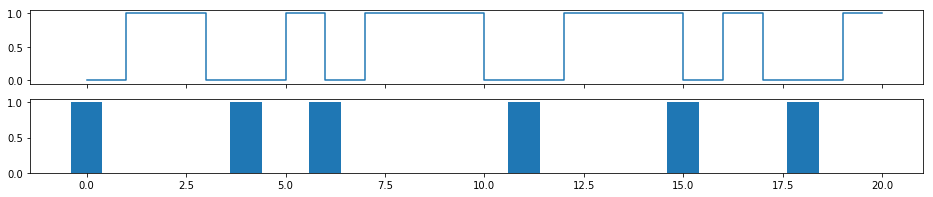

In [78]:
signals = np.random.randint(2, size=20)
print(signals)
fig, axes = plt.subplots(2, 1, figsize=(16, 3), sharex=True)
axes[0].plot(*pulses_to_square(signals))
edges = signals[1:] - signals[:-1]
axes[1].bar(np.r_[:edges.shape[0]], edges > 0)

In [69]:
signals


array([1, 0, 0, 0, 1, 1, 1, 0, 1, 1])

In [103]:
start, end = 100, 200
seq_name = '16S'
dataset = 'model_RNAs'
with h5py.File('output/patteRNA/SHAPE-MaP/{}.reactivities.h5'.format(dataset), 'r') as f:
    reactivities = f['/reactivities/' + seq_name][start:end]
with h5py.File('output/patteRNA/SHAPE-MaP/{}.viterbi.h5'.format(dataset), 'r') as f:
    viterbi = f[seq_name][start:end]
with h5py.File('output/patteRNA/SHAPE-MaP/{}.posteriors_paired.h5'.format(dataset), 'r') as f:
    posteriors = f[seq_name][start:end]
fig, axes = plt.subplots(3, 1, figsize=(16, 5), sharex=True)
axes[0].plot(*pulses_to_square(viterbi))
axes[1].plot(reactivities)
axes[2].plot(posteriors)

KeyError: "Unable to open object (object '16S' doesn't exist)"